In [ ]:
!pip install --upgrade networkx

Nodes: 10, Edges: 20 -> Time: 0.000259s, Memory: 5.22KB
Nodes: 50, Edges: 200 -> Time: 0.001540s, Memory: 7.40KB
Nodes: 100, Edges: 500 -> Time: 0.003416s, Memory: 9.72KB
Nodes: 500, Edges: 2000 -> Time: 0.024578s, Memory: 47.29KB
Nodes: 1000, Edges: 5000 -> Time: 0.072327s, Memory: 89.84KB
Nodes: 2000, Edges: 10000 -> Time: 0.192606s, Memory: 251.66KB


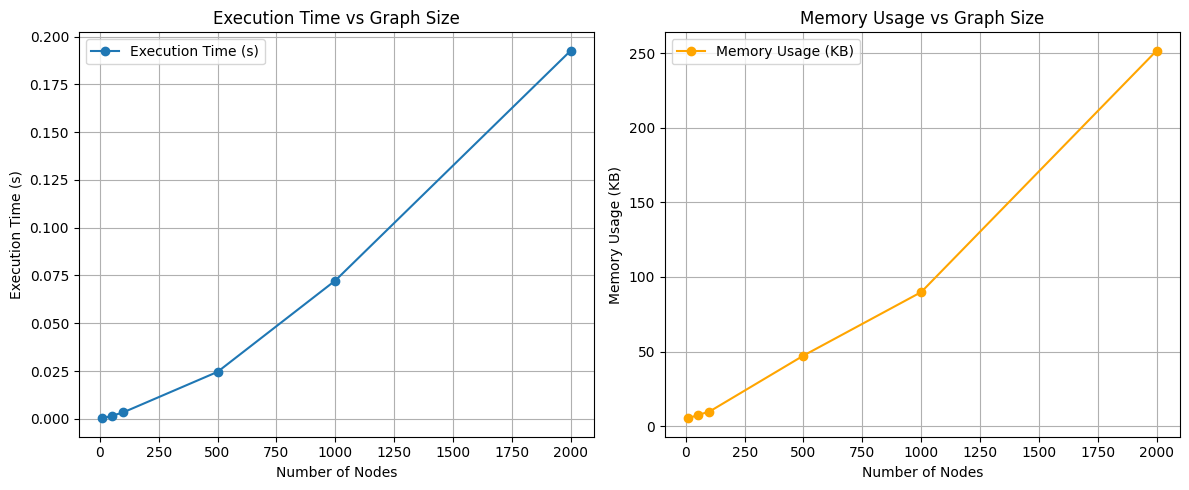

Done


In [2]:
import time
import tracemalloc
import matplotlib.pyplot as plt
import random
from graphviz import Graph

def generate_random_graph(num_nodes, num_edges):
    edges = []

    # Each node has at least one edge
    for node in range(num_nodes):
        other_node = random.choice([n for n in range(num_nodes) if n != node])
        weight = random.randint(1, 100)
        edges.append((node, other_node, weight))

    # remaining edges(Random)
    remaining_edges = num_edges - num_nodes
    for _ in range(remaining_edges):
        u, v = random.sample(range(num_nodes), 2)
        weight = random.randint(1, 100)
        edges.append((u, v, weight))

    return edges, num_nodes


def merge_sort(edges):
    if len(edges) > 1:
        mid = len(edges) // 2
        left_half = edges[:mid]
        right_half = edges[mid:]
        merge_sort(left_half)
        merge_sort(right_half)
        merge(edges, left_half, right_half)

def merge(arr, left_half, right_half):
    i = j = k = 0
    while i < len(left_half) and j < len(right_half):
        # Compare weights only
        if left_half[i][2] < right_half[j][2]:
            arr[k] = left_half[i]
            i += 1
        else:
            arr[k] = right_half[j]
            j += 1
        k += 1
    while i < len(left_half):
        arr[k] = left_half[i]
        i += 1
        k += 1
    while j < len(right_half):
        arr[k] = right_half[j]
        j += 1
        k += 1


class DSU:
    def __init__(self, n):
        self.parent = list(range(n))
        self.rank = [0] * n

    def find(self, x):
      # find root of set with that element
        if self.parent[x] != x:
            self.parent[x] = self.find(self.parent[x])
        return self.parent[x]

    def union(self, x, y):
        root_x = self.find(x)
        root_y = self.find(y)
        # to ensure no cycle is formed
        if root_x != root_y:
            if self.rank[root_x] > self.rank[root_y]:
              # for efficiency in finding cycles
                self.parent[root_y] = root_x
            elif self.rank[root_x] < self.rank[root_y]:
                self.parent[root_x] = root_y
            else:
                self.parent[root_y] = root_x
                self.rank[root_x] += 1

def kruskal(edges, num_nodes):
    # Sort edges by weight
    merge_sort(edges)
    dsu = DSU(num_nodes)
    mst = []
    total_weight = 0
    for u, v, weight in edges:
        if dsu.find(u) != dsu.find(v):
            dsu.union(u, v)
            mst.append((u, v, weight))
            total_weight += weight

    return mst, total_weight

# Visualizing
def visualize_graph(edges, mst_only, num_nodes, file_name, title):
    graph = Graph(format='png')
    graph.attr(label=title, fontsize="20")

    # Add nodes
    for i in range(num_nodes):
        graph.node(str(i), str(i))

    # Add edges
    if mst_only:
        for u, v, weight in edges:
            graph.edge(str(u), str(v), label=str(weight), color="green")
    else:
        for u, v, weight in edges:
            graph.edge(str(u), str(v), label=str(weight), color="gray")

    # Render graph
    graph.render(file_name, view=True)

# Performance analysis
def analyze_performance(graphs):
    node_sizes = [graph[1] for graph in graphs]
    edge_sizes = [len(graph[0]) for graph in graphs]
    times = []
    memory = []
    mst=[]

    for cur_graph in graphs:
        edges = cur_graph[0]
        num_nodes = cur_graph[1]
        num_edges = len(edges)



        # Measure execution time and memory
        start_time = time.time()
        tracemalloc.start()
        mst.append(kruskal(edges, num_nodes))

        current, peak = tracemalloc.get_traced_memory()
        tracemalloc.stop()
        elapsed_time = time.time() - start_time

        # Record results
        times.append(elapsed_time)
        memory.append(peak / 1024)  # in KBs

        print(f"Nodes: {num_nodes}, Edges: {num_edges} -> Time: {elapsed_time:.6f}s, Memory: {peak / 1024:.2f}KB")


    # Plot results
    plt.figure(figsize=(12, 5))

    # Execution time plot
    plt.subplot(1, 2, 1)
    plt.plot(node_sizes, times, marker='o', label='Execution Time (s)')
    plt.xlabel("Number of Nodes")
    plt.ylabel("Execution Time (s)")
    plt.title("Execution Time vs Graph Size")
    plt.grid(True)
    plt.legend()

    # Memory usage plot
    plt.subplot(1, 2, 2)
    plt.plot(node_sizes, memory, marker='o', color='orange', label='Memory Usage (KB)')
    plt.xlabel("Number of Nodes")
    plt.ylabel("Memory Usage (KB)")
    plt.title("Memory Usage vs Graph Size")
    plt.grid(True)
    plt.legend()

    plt.tight_layout()
    plt.savefig("performance_analysis.png")
    plt.show()
    return mst,times,memory

if __name__ == "__main__":
  graphs=[]

  graphs.append(generate_random_graph(10, 20))
  graphs.append(generate_random_graph(50, 200))
  graphs.append(generate_random_graph(100, 500))
  graphs.append(generate_random_graph(500, 2000))
  graphs.append(generate_random_graph(1000, 5000))
  graphs.append(generate_random_graph(2000, 10000))
  mst,times,memory=analyze_performance(graphs)
  #Visualize small graphs only
  for i in range(2):
        cur_graph = graphs[i]
        visualize_graph(cur_graph[0], mst_only=False, num_nodes=cur_graph[1], file_name=f"{cur_graph[1]}_nodes_graph", title="Original Graph")
        visualize_graph(mst[i][0], mst_only=True, num_nodes=cur_graph[1], file_name=f"MST_{cur_graph[1]}_graph", title="Reduced")
  print("Done")


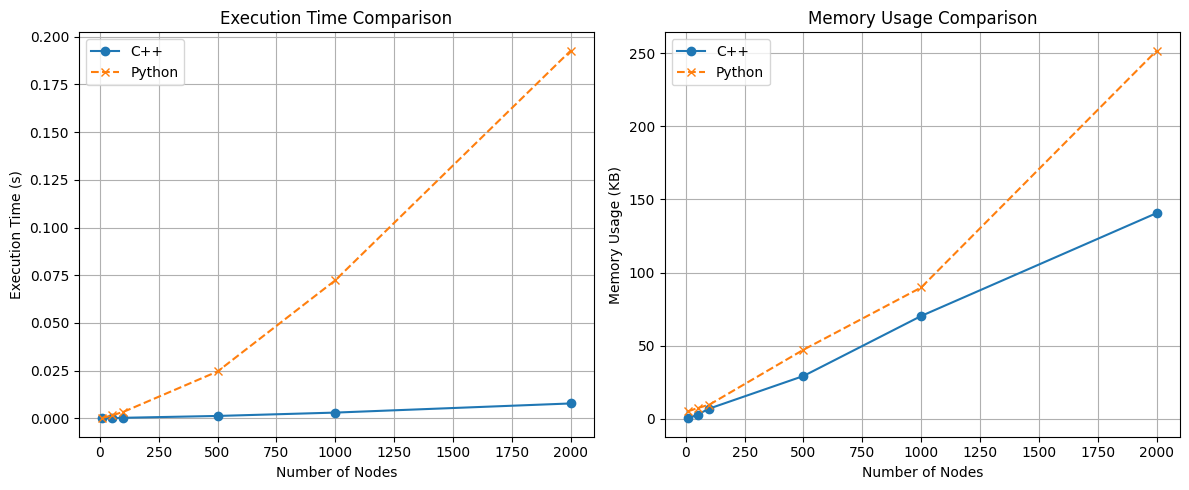

In [4]:
import pandas as pd
import matplotlib.pyplot as plt

cpp_data = pd.read_csv('cpp_performance_analysis.csv')

previous_nodes = [10, 50, 100, 500, 1000, 2000]

# Plotting
plt.figure(figsize=(12, 5))

# Execution Time
plt.subplot(1, 2, 1)
plt.plot(cpp_data['Nodes'], cpp_data['ExecutionTime(s)'], marker='o', label='C++')
plt.plot(previous_nodes, times, marker='x', linestyle='--', label='Python')
plt.xlabel("Number of Nodes")
plt.ylabel("Execution Time (s)")
plt.title("Execution Time Comparison")
plt.legend()
plt.grid(True)

# Memory Usage
plt.subplot(1, 2, 2)
plt.plot(cpp_data['Nodes'], cpp_data['MemoryUsage(KB)'], marker='o', label='C++')
plt.plot(previous_nodes, memory, marker='x', linestyle='--', label='Python')
plt.xlabel("Number of Nodes")
plt.ylabel("Memory Usage (KB)")
plt.title("Memory Usage Comparison")
plt.legend()
plt.grid(True)

plt.tight_layout()
plt.show()